In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.layers import Dense, Activation, LSTM, GRU, Input, concatenate, dot
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
df = pd.read_csv('data_python_dynamic.csv')
T2 = df['Y0']
T_new = []
for i in range(1600):
    tmp = [0] * 9
    tmp.extend(T2[i * 146: (i + 1)* 146])
    for j in range(len(tmp) - 10):
        T_new.append(tmp[j: j + 10])
T_new = np.array(T_new)
train_data = np.load('python_train_data_dynamic.csv.npy')
target = np.load('python_train_target_data_dynamic.csv.npy').reshape(-1, 1)
print(target.shape)
stdsc = StandardScaler()
T = target
P = train_data
P = stdsc.fit_transform(P)
joblib.dump(stdsc, "stdsc_python_dynamic.m")
P_T = T_new
train_num = int(P.shape[0] * 0.8)
test_num = int(P.shape[0] * 0.2)
P_Train = P[:train_num, :]
T_Train = T[:train_num, :]
P_Test = P[train_num:, :]
T_Test = T[train_num:, :]
P_Train = P_Train.reshape(train_num,1,60)
P_Test = P_Test.reshape(test_num,1,60)
T_new_Train = P_T[:train_num, :]
T_new_Test = P_T[train_num:, :]
T_new_Train = T_new_Train.reshape(train_num,1,10)
T_new_Test = T_new_Test.reshape(test_num,1,10)
print(P_Train.shape, T_new_Train.shape, T_Train.shape)

(232000, 1)
(185600, 1, 60) (185600, 1, 10) (185600, 1)


In [9]:
inputs = Input(shape=(1, 60))
encoder = GRU(units=16, recurrent_dropout=0.2, activation="tanh", return_sequences=True)(inputs)
encoder = GRU(units=8, recurrent_dropout=0.2, activation="tanh", return_sequences=True)(encoder)
T_input = Input(shape=(1, 10))
decoder = GRU(units=8, recurrent_dropout=0.2, activation="tanh", return_sequences=True)(T_input)
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder], axes=[2,1])
decoder_combined_context = concatenate([context, decoder])
output = Dense(64, activation="tanh")(decoder_combined_context)
output = Dense(16, activation='relu')(output)
main_output = Dense(1, name='main_output')(output)
model = Model(inputs=[inputs, T_input], outputs=main_output)

In [10]:
T_Train = T_Train.reshape(train_num,1,1)
T_Test = T_Test.reshape(test_num,1,1)
model.compile(loss='mse', optimizer='adam')
history = model.fit([P_Train, T_new_Train], T_Train, batch_size=146, epochs=20,
                    validation_data=([P_Test,T_new_Test], T_Test))

Train on 185600 samples, validate on 46400 samples
Epoch 1/20
185600/185600 [==============================] - 8s 45us/step - loss: 2.6345e-05 - val_loss: 1.3569e-06
Epoch 2/20
185600/185600 [==============================] - 6s 32us/step - loss: 8.3671e-07 - val_loss: 5.9125e-07
Epoch 3/20
185600/185600 [==============================] - 6s 32us/step - loss: 8.0834e-07 - val_loss: 8.1565e-07
Epoch 4/20
185600/185600 [==============================] - 6s 33us/step - loss: 6.6122e-07 - val_loss: 8.5295e-07
Epoch 5/20
185600/185600 [==============================] - 6s 34us/step - loss: 7.6456e-07 - val_loss: 1.2157e-06
Epoch 6/20
185600/185600 [==============================] - 7s 36us/step - loss: 5.3239e-07 - val_loss: 1.1766e-06
Epoch 7/20
185600/185600 [==============================] - 6s 35us/step - loss: 5.2970e-07 - val_loss: 1.8288e-07
Epoch 8/20
185600/185600 [==============================] - 7s 35us/step - loss: 4.0121e-07 - val_loss: 7.3390e-07
Epoch 9/20
185600/185600 [===

In [11]:
pred = model.predict([P_Test, T_new_Test])
pred.shape

(46400, 1, 1)

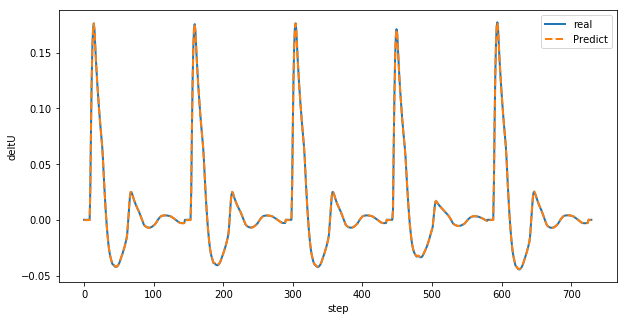

In [12]:
pred1 = [pred[i,0,0] for i in range(730)]
real = [T_Test[i,0,0] for i in range(730)]
plt.figure(figsize=(10,5))
plt.plot(real, linewidth=2, label='real')
plt.plot(pred1, linewidth=2, label='Predict', linestyle='--')
plt.xlabel('step')
plt.ylabel('deltU')
plt.legend()
plt.show()

In [13]:
model.save('new_encoder_decoder_model_dynamic.h5')